In [30]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e2_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e2_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e2_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e2_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'








In [31]:
x = syp.Symbol('x')
y = syp.Symbol('y')
a00, a01, a02, a03, a10, a11, a12, a13 = syp.symbols('a00 a01 a02 a03 a10 a11 a12 a13')
a20, a21, a22, a23, a30, a31, a32, a33 = syp.symbols('a20 a21 a22 a23 a30 a31 a32 a33')

p = a00 + a01*y + a02*y**2 + a03*y**3\
+ a10*x + a11*x*y + a12*x*y**2 + a13*x*y**3\
+ a20*x**2 + a21*x**2*y + a22*x**2*y**2 + a23*x**2*y**3\
+ a30*x**3 + a31*x**3*y + a32*x**3*y**2 + a33*x**3*y**3 

px = syp.diff(p, x)
py = syp.diff(p, y)
pxy = syp.diff(p, x, y)

df = pd.DataFrame(columns=['function', 'evaluation'])

for i in range(2):
    for j in range(2):
        function = 'p({}, {})'.format(j,i)
        df.loc[len(df)] = [function, p.subs({x:j, y:i})]
for i in range(2):
    for j in range(2):
        function = 'px({}, {})'.format(j,i)
        df.loc[len(df)] = [function, px.subs({x:j, y:i})]
for i in range(2):
    for j in range(2):
        function = 'py({}, {})'.format(j,i)
        df.loc[len(df)] = [function, py.subs({x:j, y:i})]
for i in range(2):
    for j in range(2):
        function = 'pxy({}, {})'.format(j,i)
        df.loc[len(df)] = [function, pxy.subs({x:j, y:i})]

eqns = df['evaluation'].tolist()
symbols = [a00,a01,a02,a03,a10,a11,a12,a13,a20,a21,a22,a23,a30,a31,a32,a33]
A = syp.linear_eq_to_matrix(eqns, *symbols)[0]
A = np.array(A.inv()).astype(np.float64)

def bicubic_interpolation(xi, yi, zi, xnew, ynew):

    # check sorting
    if np.any(np.diff(xi) < 0) and np.any(np.diff(yi) < 0) and\
    np.any(np.diff(xnew) < 0) and np.any(np.diff(ynew) < 0):
        raise ValueError('data are not sorted')

    if zi.shape != (xi.size, yi.size):
        print(xi.size,yi.size,zi.shape)
        raise ValueError('zi is not set properly use np.meshgrid(xi, yi)')

    z = np.zeros((xnew.size, ynew.size))

    deltax = xi[1] - xi[0]
    deltay = yi[1] - yi[0] 
    for n, x in enumerate(xnew):
        for m, y in enumerate(ynew):

            if xi.min() <= x <= xi.max() and yi.min() <= y <= yi.max():

                i = np.searchsorted(xi, x) - 1
                j = np.searchsorted(yi, y) - 1

                x0  = xi[i-1]
                x1  = xi[i]
                x2  = xi[i+1]
                x3  = x1+2*deltax

                y0  = yi[j-1]
                y1  = yi[j]
                y2  = yi[j+1]
                y3  = y1+2*deltay

                px = (x-x1)/(x2-x1)
                py = (y-y1)/(y2-y1)

                f00 = zi[i-1, j-1]      #row0 col0 >> x0,y0
                f01 = zi[i-1, j]        #row0 col1 >> x1,y0
                f02 = zi[i-1, j+1]      #row0 col2 >> x2,y0

                f10 = zi[i, j-1]        #row1 col0 >> x0,y1
                f11 = p00 = zi[i, j]    #row1 col1 >> x1,y1
                f12 = p01 = zi[i, j+1]  #row1 col2 >> x2,y1

                f20 = zi[i+1,j-1]       #row2 col0 >> x0,y2
                f21 = p10 = zi[i+1,j]   #row2 col1 >> x1,y2
                f22 = p11 = zi[i+1,j+1] #row2 col2 >> x2,y2

                if 0 < i < xi.size-2 and 0 < j < yi.size-2:

                    f03 = zi[i-1, j+2]      #row0 col3 >> x3,y0

                    f13 = zi[i,j+2]         #row1 col3 >> x3,y1

                    f23 = zi[i+1,j+2]       #row2 col3 >> x3,y2

                    f30 = zi[i+2,j-1]       #row3 col0 >> x0,y3
                    f31 = zi[i+2,j]         #row3 col1 >> x1,y3
                    f32 = zi[i+2,j+1]       #row3 col2 >> x2,y3
                    f33 = zi[i+2,j+2]       #row3 col3 >> x3,y3

                elif i<=0: 

                    f03 = f02               #row0 col3 >> x3,y0

                    f13 = f12               #row1 col3 >> x3,y1

                    f23 = f22               #row2 col3 >> x3,y2

                    f30 = zi[i+2,j-1]       #row3 col0 >> x0,y3
                    f31 = zi[i+2,j]         #row3 col1 >> x1,y3
                    f32 = zi[i+2,j+1]       #row3 col2 >> x2,y3
                    f33 = f32               #row3 col3 >> x3,y3             

                elif j<=0:

                    f03 = zi[i-1, j+2]      #row0 col3 >> x3,y0

                    f13 = zi[i,j+2]         #row1 col3 >> x3,y1

                    f23 = zi[i+1,j+2]       #row2 col3 >> x3,y2

                    f30 = f20               #row3 col0 >> x0,y3
                    f31 = f21               #row3 col1 >> x1,y3
                    f32 = f22               #row3 col2 >> x2,y3
                    f33 = f23               #row3 col3 >> x3,y3


                elif i == xi.size-2 or j == yi.size-2:

                    f03 = f02               #row0 col3 >> x3,y0

                    f13 = f12               #row1 col3 >> x3,y1

                    f23 = f22               #row2 col3 >> x3,y2

                    f30 = f20               #row3 col0 >> x0,y3
                    f31 = f21               #row3 col1 >> x1,y3
                    f32 = f22               #row3 col2 >> x2,y3
                    f33 = f23               #row3 col3 >> x3,y3

                px00 = (f12 - f10)/2*deltax
                px01 = (f22 - f20)/2*deltax 
                px10 = (f13 - f11)/2*deltax 
                px11 = (f23 - f21)/2*deltax

                py00 = (f21 - f01)/2*deltay
                py01 = (f22 - f02)/2*deltay
                py10 = (f31 - f11)/2*deltay
                py11 = (f32 - f12)/2*deltay

                pxy00 = ((f22-f20) - (f02-f00))/4*deltax*deltay
                pxy01 = ((f32-f30) - (f12-f10))/4*deltax*deltay
                pxy10 = ((f23-f21) - (f03-f01))/4*deltax*deltay
                pxy11 = ((f33-f31) - (f13-f11))/4*deltax*deltay


                f = np.array([p00,  p01,  p10, p11,
                              px00,  px01,  px10, px11,
                              py00, py01,  py10,  py11,
                              pxy00,  pxy01, pxy10, pxy11])

                a = A@f

                a = a.reshape(4,4).transpose()
                z[n,m] = np.array([1, px, px**2, px**3]) @ a @ np.array([1, py, py**2, py**3])

    return z


fitsdata_b3 = fits.open(w51e_b3_almaimf_conv)
wcs_b3 = WCS(fitsdata_b3[0].header,naxis=2)
xypos_image_b3 = [930, 1140, 780, 1170]
xypos_image_b3 = np.array([[780, 930],[1170,930],[780,1140],[1170,1140]])
xypos_sky_b3 = wcs_b3.wcs_pix2world(xypos_image_b3,0)


fitsdata_b6 = fits.open(w51e_b6_almaimf_conv)
wcs_b6 = WCS(fitsdata_b6[0].header,naxis=2)
xypos_image_b6 = wcs_b6.wcs_world2pix(xypos_sky_b3,0)

print(xypos_image_b6)
print(xypos_image_b6[0][0])
print(xypos_image_b6[1][0])
print(xypos_image_b6[0][1])
print(xypos_image_b6[2][1])

imageb3 = fitsdata_b3[0].data
imageb6 = fitsdata_b6[0].data

imageb3_cut = imageb3[780:1171,930:1141]
imageb6_cut = imageb6[int(xypos_image_b6[0][0]):int(xypos_image_b6[1][0]),int(xypos_image_b6[0][1]):int(xypos_image_b6[2][1])]
x_b6 = np.arange(int(xypos_image_b6[0][1]),int(xypos_image_b6[2][1]))
y_b6 = np.arange(int(xypos_image_b6[0][0]),int(xypos_image_b6[1][0]))
xnew = np.linspace(int(xypos_image_b6[0][1]),int(xypos_image_b6[2][1]),num=imageb3.shape[0])
ynew = np.linspace(int(xypos_image_b6[0][0]),int(xypos_image_b6[1][0]),num=imageb3.shape[1])

imageb6_cut_bicubic_interpol = bicubic_interpolation(y_b6,x_b6,imageb6_cut,ynew,xnew)


#interpolate.interp2d(y_b6, x_b6, image_b6_cut,  )


#plt.imshow(imageb3[780:1170,930:1140],origin='lower')







[[2112.         2335.49553602]
 [2736.         2335.49553603]
 [2112.         2671.49553604]
 [2736.         2671.49553605]]
2112.000000000494
2735.9999999973616
2335.495536023835
2671.4955360435492


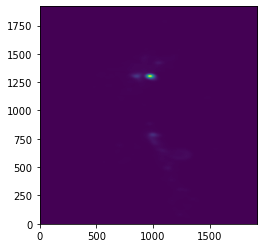

In [32]:
plt.imshow(imageb6_cut_bicubic_interpol,origin='lower')

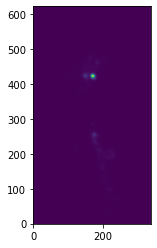

In [21]:
plt.imshow(imageb6[int(xypos_image_b6[0][0]):int(xypos_image_b6[1][0]),int(xypos_image_b6[0][1]):int(xypos_image_b6[2][1])],origin='lower')


